In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


✅ Using device: cuda


In [ ]:
import uproot
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# File paths
train_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"
test_path  = r"C:\Users\Agastya\OneDrive\Desktop\test_root_file.root"

# Open ROOT files
train_tree = uproot.open(train_path)["deepntuplizer/tree"]
test_tree  = uproot.open(test_path)["deepntuplizer/tree"]

# Select features and labels
feature_cols = ["jet_pt", "jet_eta", "jet_phi", "jet_corr_pt", "npv"]
label_cols = ["isB", "isBB", "isC", "isG", "isS", "isUD"]

# Convert to Pandas DataFrames
train_df = train_tree.arrays(feature_cols + label_cols, library="pd")
test_df  = test_tree.arrays(feature_cols + label_cols, library="pd")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


✅ Train shape: (200000, 11)
✅ Test shape: (200000, 11)


In [ ]:
import uproot
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# File paths
train_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"
test_path  = r"C:\Users\Agastya\OneDrive\Desktop\test_root_file.root"

# Open ROOT files
train_tree = uproot.open(train_path)["deepntuplizer/tree"]
test_tree  = uproot.open(test_path)["deepntuplizer/tree"]

# Jet branches
jet_branches = [
    "fj_pt", "fj_eta", "fj_phi", "fj_mass",
    "fj_sdmass", "fj_tau1", "fj_tau2", "fj_tau21",
    "npv", "rho",
    "fj_isBB"
]

df = train_tree.arrays(jet_branches, library="pd")

df = df.rename(columns={"fj_isBB": "is_Higgs"})
df = df.dropna()

#Features and labels 
X = df.drop(columns=["is_Higgs"]).values
y = df["is_Higgs"].values

#Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Final dataset shape:", X.shape)
print("Class distribution:\n", df["is_Higgs"].value_counts())


✅ Final dataset shape: (200000, 10)
✅ Class distribution:
 is_Higgs
0    167024
1     32976
Name: count, dtype: int64


In [ ]:
import uproot
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# File paths 
train_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"
test_path  = r"C:\Users\Agastya\OneDrive\Desktop\test_root_file.root"

# Open ROOT files
train_tree = uproot.open(train_path)["deepntuplizer/tree"]
test_tree  = uproot.open(test_path)["deepntuplizer/tree"]

#Jet branches
jet_branches = [
    "fj_pt", "fj_eta", "fj_phi", "fj_mass",
    "fj_sdmass", "fj_tau1", "fj_tau2", "fj_tau21",
    "npv", "rho",
    "fj_isBB"
]

# Convert both files to DataFrames
train_df = train_tree.arrays(jet_branches, library="pd")
test_df  = test_tree.arrays(jet_branches, library="pd")

# Rename labels
train_df = train_df.rename(columns={"fj_isBB": "is_Higgs"})
test_df  = test_df.rename(columns={"fj_isBB": "is_Higgs"})

# Drop missing values
train_df = train_df.dropna()
test_df  = test_df.dropna()

# Features and labels 
X_train = train_df.drop(columns=["is_Higgs"]).values
y_train = train_df["is_Higgs"].values

X_test = test_df.drop(columns=["is_Higgs"]).values
y_test = test_df["is_Higgs"].values

#Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Train shape:", X_train.shape)
print("✅ Test shape:", X_test.shape)
print("Train class distribution:\n", train_df["is_Higgs"].value_counts())
print("Test class distribution:\n", test_df["is_Higgs"].value_counts())



✅ Train shape: (200000, 10)
✅ Test shape: (200000, 10)
Train class distribution:
 is_Higgs
0    167024
1     32976
Name: count, dtype: int64
Test class distribution:
 is_Higgs
0    166873
1     33127
Name: count, dtype: int64


In [ ]:
 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create Datasets and Loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(" Dataloaders created!")


✅ Using device: cuda
✅ Dataloaders created!


In [ ]:
class HiggsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(HiggsClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = HiggsClassifier(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [19]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t.to(device)).cpu().numpy()
        acc = ((preds > 0.5) == y_test_t.numpy()).mean()

    print(f"Epoch {epoch+1}/10 - Train Loss: {total_loss/len(train_loader):.4f} - Test Acc: {acc:.4f}")


Epoch 1/10 - Train Loss: 0.3112 - Test Acc: 0.8908
Epoch 2/10 - Train Loss: 0.2875 - Test Acc: 0.8924
Epoch 3/10 - Train Loss: 0.2835 - Test Acc: 0.8919
Epoch 4/10 - Train Loss: 0.2816 - Test Acc: 0.8926
Epoch 5/10 - Train Loss: 0.2805 - Test Acc: 0.8914
Epoch 6/10 - Train Loss: 0.2797 - Test Acc: 0.8915
Epoch 7/10 - Train Loss: 0.2789 - Test Acc: 0.8940
Epoch 8/10 - Train Loss: 0.2784 - Test Acc: 0.8939
Epoch 9/10 - Train Loss: 0.2779 - Test Acc: 0.8940
Epoch 10/10 - Train Loss: 0.2778 - Test Acc: 0.8936


In [20]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94    166873
           1       0.79      0.49      0.60     33127

    accuracy                           0.89    200000
   macro avg       0.85      0.73      0.77    200000
weighted avg       0.89      0.89      0.88    200000



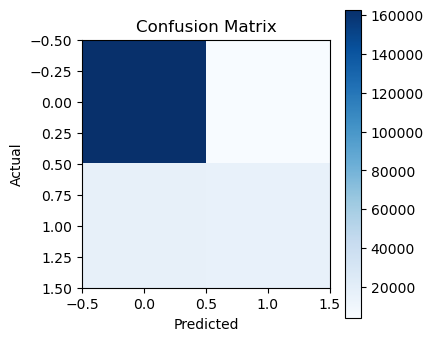

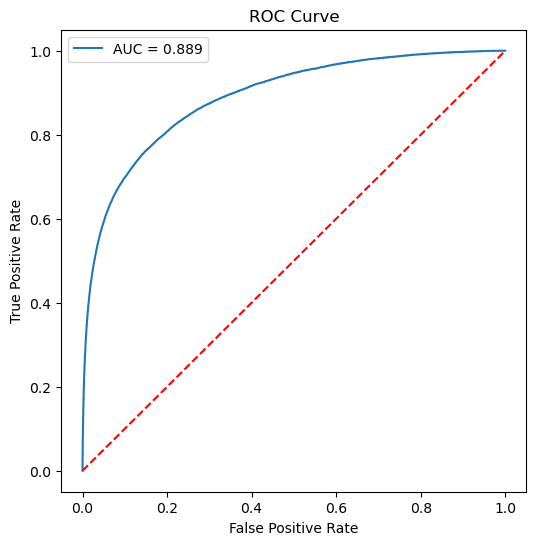

In [22]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
